# Building Data Genome - Geographical Regions Load Profiles and Predictions



## Installations and Setting up

In [ ]:
#Installation

In [35]:
# Import required packages
import pandas as pd
import numpy as np
from google.colab import drive
import warnings

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import gc
import geopandas as gpd
from shapely.geometry import Point, Polygon

pd.set_option('display.max_colwidth', None)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
!ls '/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/'

chilledwater_cleaned.csv  hotwater_cleaned.csv	  solar_cleaned.csv  weather.csv
electricity_cleaned.csv   irrigation_cleaned.csv  steam_cleaned.csv
gas_cleaned.csv		  metadata.csv		  water_cleaned.csv


In [36]:
#Import csv data into dataframes
#Energy related
df_solar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/solar_cleaned.csv')
df_water = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/water_cleaned.csv')
df_electricity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/electricity_cleaned.csv')
df_gas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/gas_cleaned.csv')
df_hotwater = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/hotwater_cleaned.csv')
df_irrigation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/irrigation_cleaned.csv')
df_solar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/solar_cleaned.csv')
df_steam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/steam_cleaned.csv')

#Metadata
df_metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/metadata.csv')

#Weather
df_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/weather.csv')

## Description of the Metadata Dataset (as provided by the authors)



    building_id: building code-name with the structure SiteID_SimplifiedUsage_UniqueName.
    site_id: animal-code-name for the site.
    building_id_kaggle: building ID used for the Kaggle competition (numeric).
    site_id_kaggle: site ID used for the Kaggle competition (numeric).
    primaryspaceusage: Primary space usage of all buildings is mapped using the energystar scheme building description types.
    sub_primaryspaceusage: energystar scheme building description types subcategory.
    sqm: Floor area of building in square meters (m2).
    lat: Latitude of building location to city level.
    lng: Longitude of building location to city level.
    timezone: site's timezone.
    electricity: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    hotwater: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    chilledwater: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    steam: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    water: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    irrigation: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    solar: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    gas: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    industry: Industry type corresponding to building.
    subindustry: More detailed breakdown of Industry type corresponding to building.
    heatingtype: Type of heating in corresponding building.
    yearbuilt: Year corresponding to when building was first constructed, in the format YYYY.
    date_opened: Date building was opened for use, in the format D/M/YYYY.
    numberoffloors: Number of floors corresponding to building.
    occupants: Usual number of occupants in the building.
    energystarscore: Rating of building corresponding to building energystar scheme (Energy Star Score).
    eui: Energy use intensity of the building (kWh/year/m2).
    site_eui: Energy (Consumed/Purchased) use intensity of the site (kWh/year/m2).
    source_eui: Total primary energy consumption normalized by area (Takes into account conversion efficiency of primary energy into secondary energy).
    leed_level: LEED rating of the building (Leadership in Energy and Environmental Design), most widely used green building rating system.
    rating: Other building energy ratings.



## Mapping the buildings

In [ ]:
# Download the Natural Earth low-resolution data
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

# Read the shapefile into a GeoDataFrame
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Exclude Antarctica and Fr. S. Antarctic Lands
world = world[(world.NAME != "Antarctica") & (world.NAME != "Fr. S. Antarctic Lands")]

# Coordinate reference system used in this map
world.crs

# All the sites
sites = df_metadata[["site_id","lat","lng"]].groupby("site_id").median()

# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (sites["lng"], sites["lat"])]

# Creates geoDataFrame
geo_sites = gpd.GeoDataFrame(sites, crs = world.crs, geometry = geometry)

As can be seen below, we have buildings situated in very distinct geographical regions, with their own building regulations and weather conditions. We would like to know if there are some significant differences between them visible via time series analysis.

<Axes: >

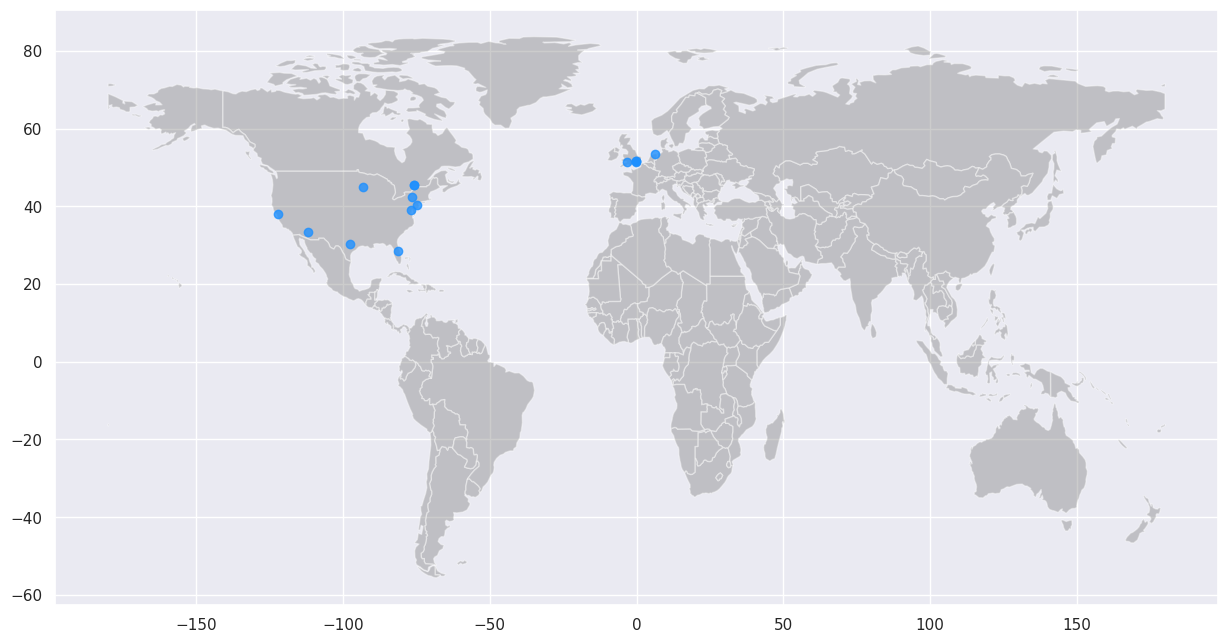

In [7]:
# Plot
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize = (15,15))
world.plot(ax = ax, alpha = 0.4, color = "grey")
geo_sites.plot(ax = ax, alpha = 0.8, color = "dodgerblue")

## Examine buildings per top 5 most frequent timezones

The top 5 most frequent timezones are US/Eastern, US/Central, Europe/London, US/Mountain and US/Pacific. They all have rather different climates and in some cases perhaps building regulations.

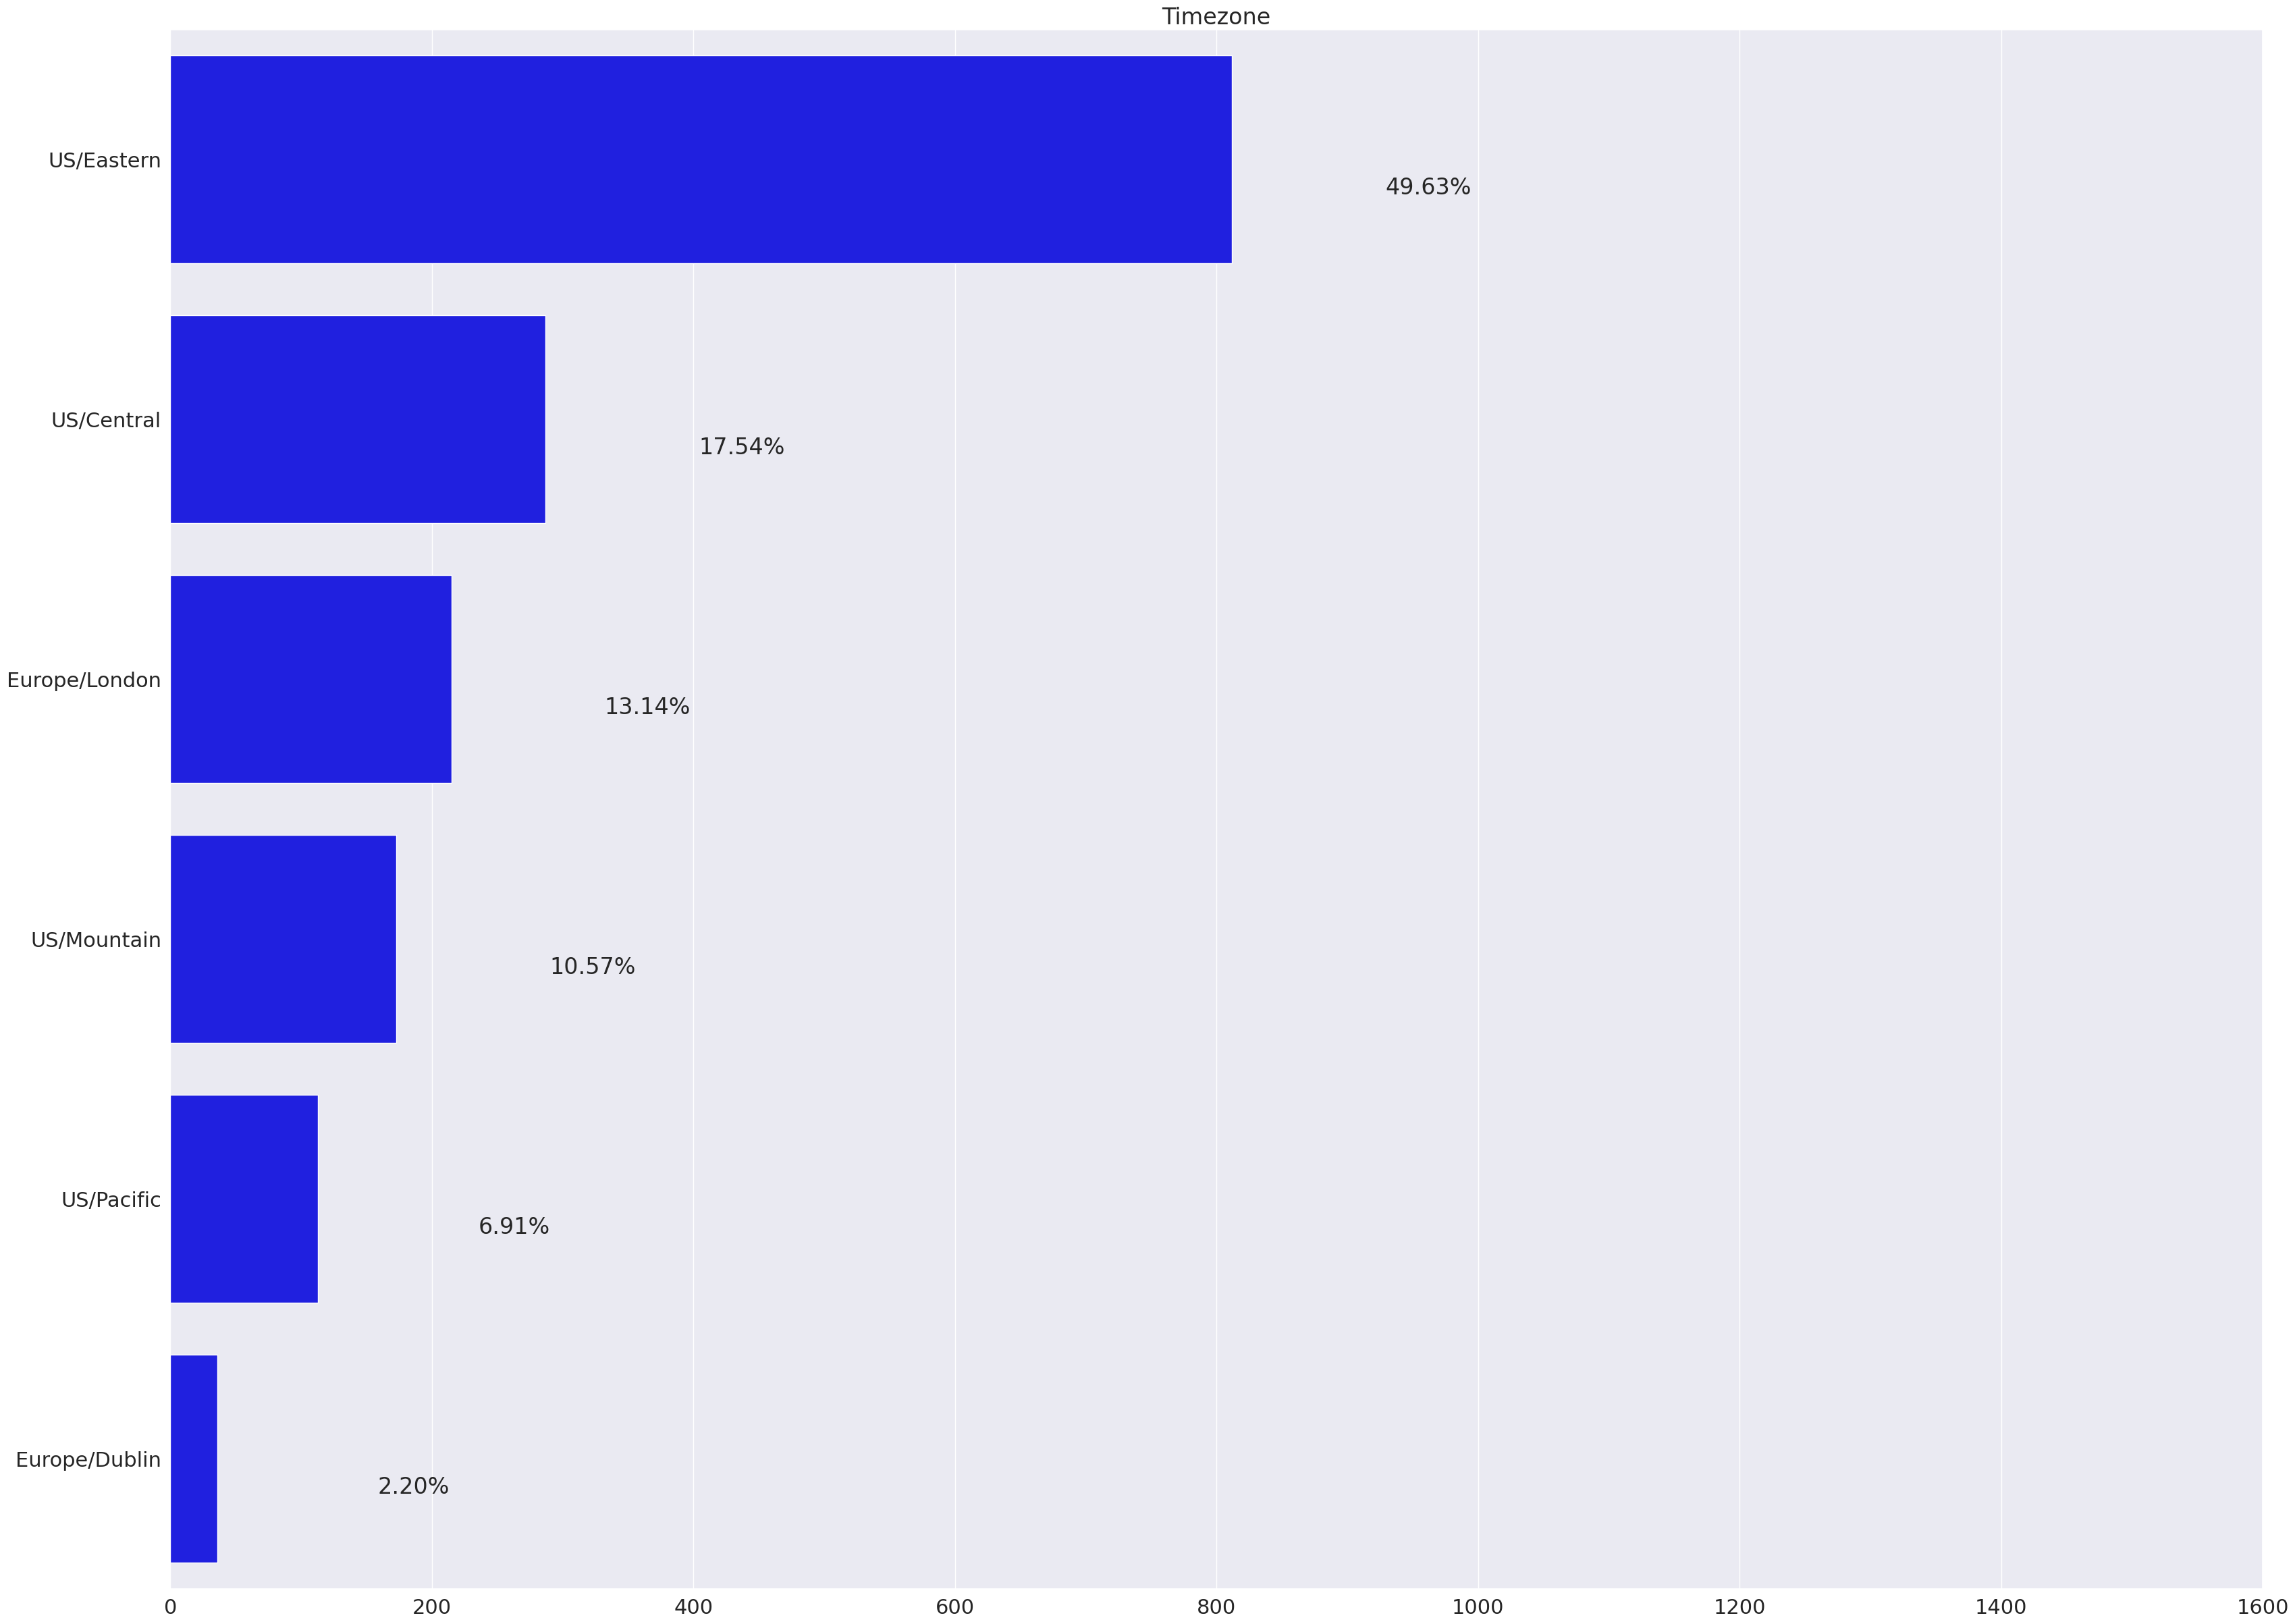

In [37]:
sns.set(rc={'figure.figsize': (40, 30)})
sns.set(font_scale=2)

# Create a figure and a single subplot
fig, ax = plt.subplots(1, 1) # or fig, ax = plt.subplots()

# timezone countplot in decreasing order
# ax5 = axes[4] # This line is not needed anymore as we only have one axis
g5 = sns.countplot(data=df_metadata, y="timezone", color='blue', ax=ax, orient="h", order = df_metadata['timezone'].value_counts().index)
ax.title.set_text('Timezone')
ax.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage
total = float(len(df_metadata)) # number of buildings
for p in g5.patches:
    width = p.get_width()
    g5.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center")

plt.show()

In [38]:
# Keep only buildings of the top 5 regions in our dataset:
df_metadata = df_metadata[df_metadata["timezone"].isin(["US/Eastern", "US/Central", "Europe/London", "US/Mountain", "US/Pacific"])]

In [41]:
df_metadata["timezone"].value_counts()

,count
timezone,
US/Eastern,812
US/Central,287
Europe/London,215
US/Mountain,173
US/Pacific,113


## Run the same features frequencies plots as in the authors' notebooks

We run the same frequencies' plots as the authors of the other notebooks did, but we do so by separating the buildings by region:

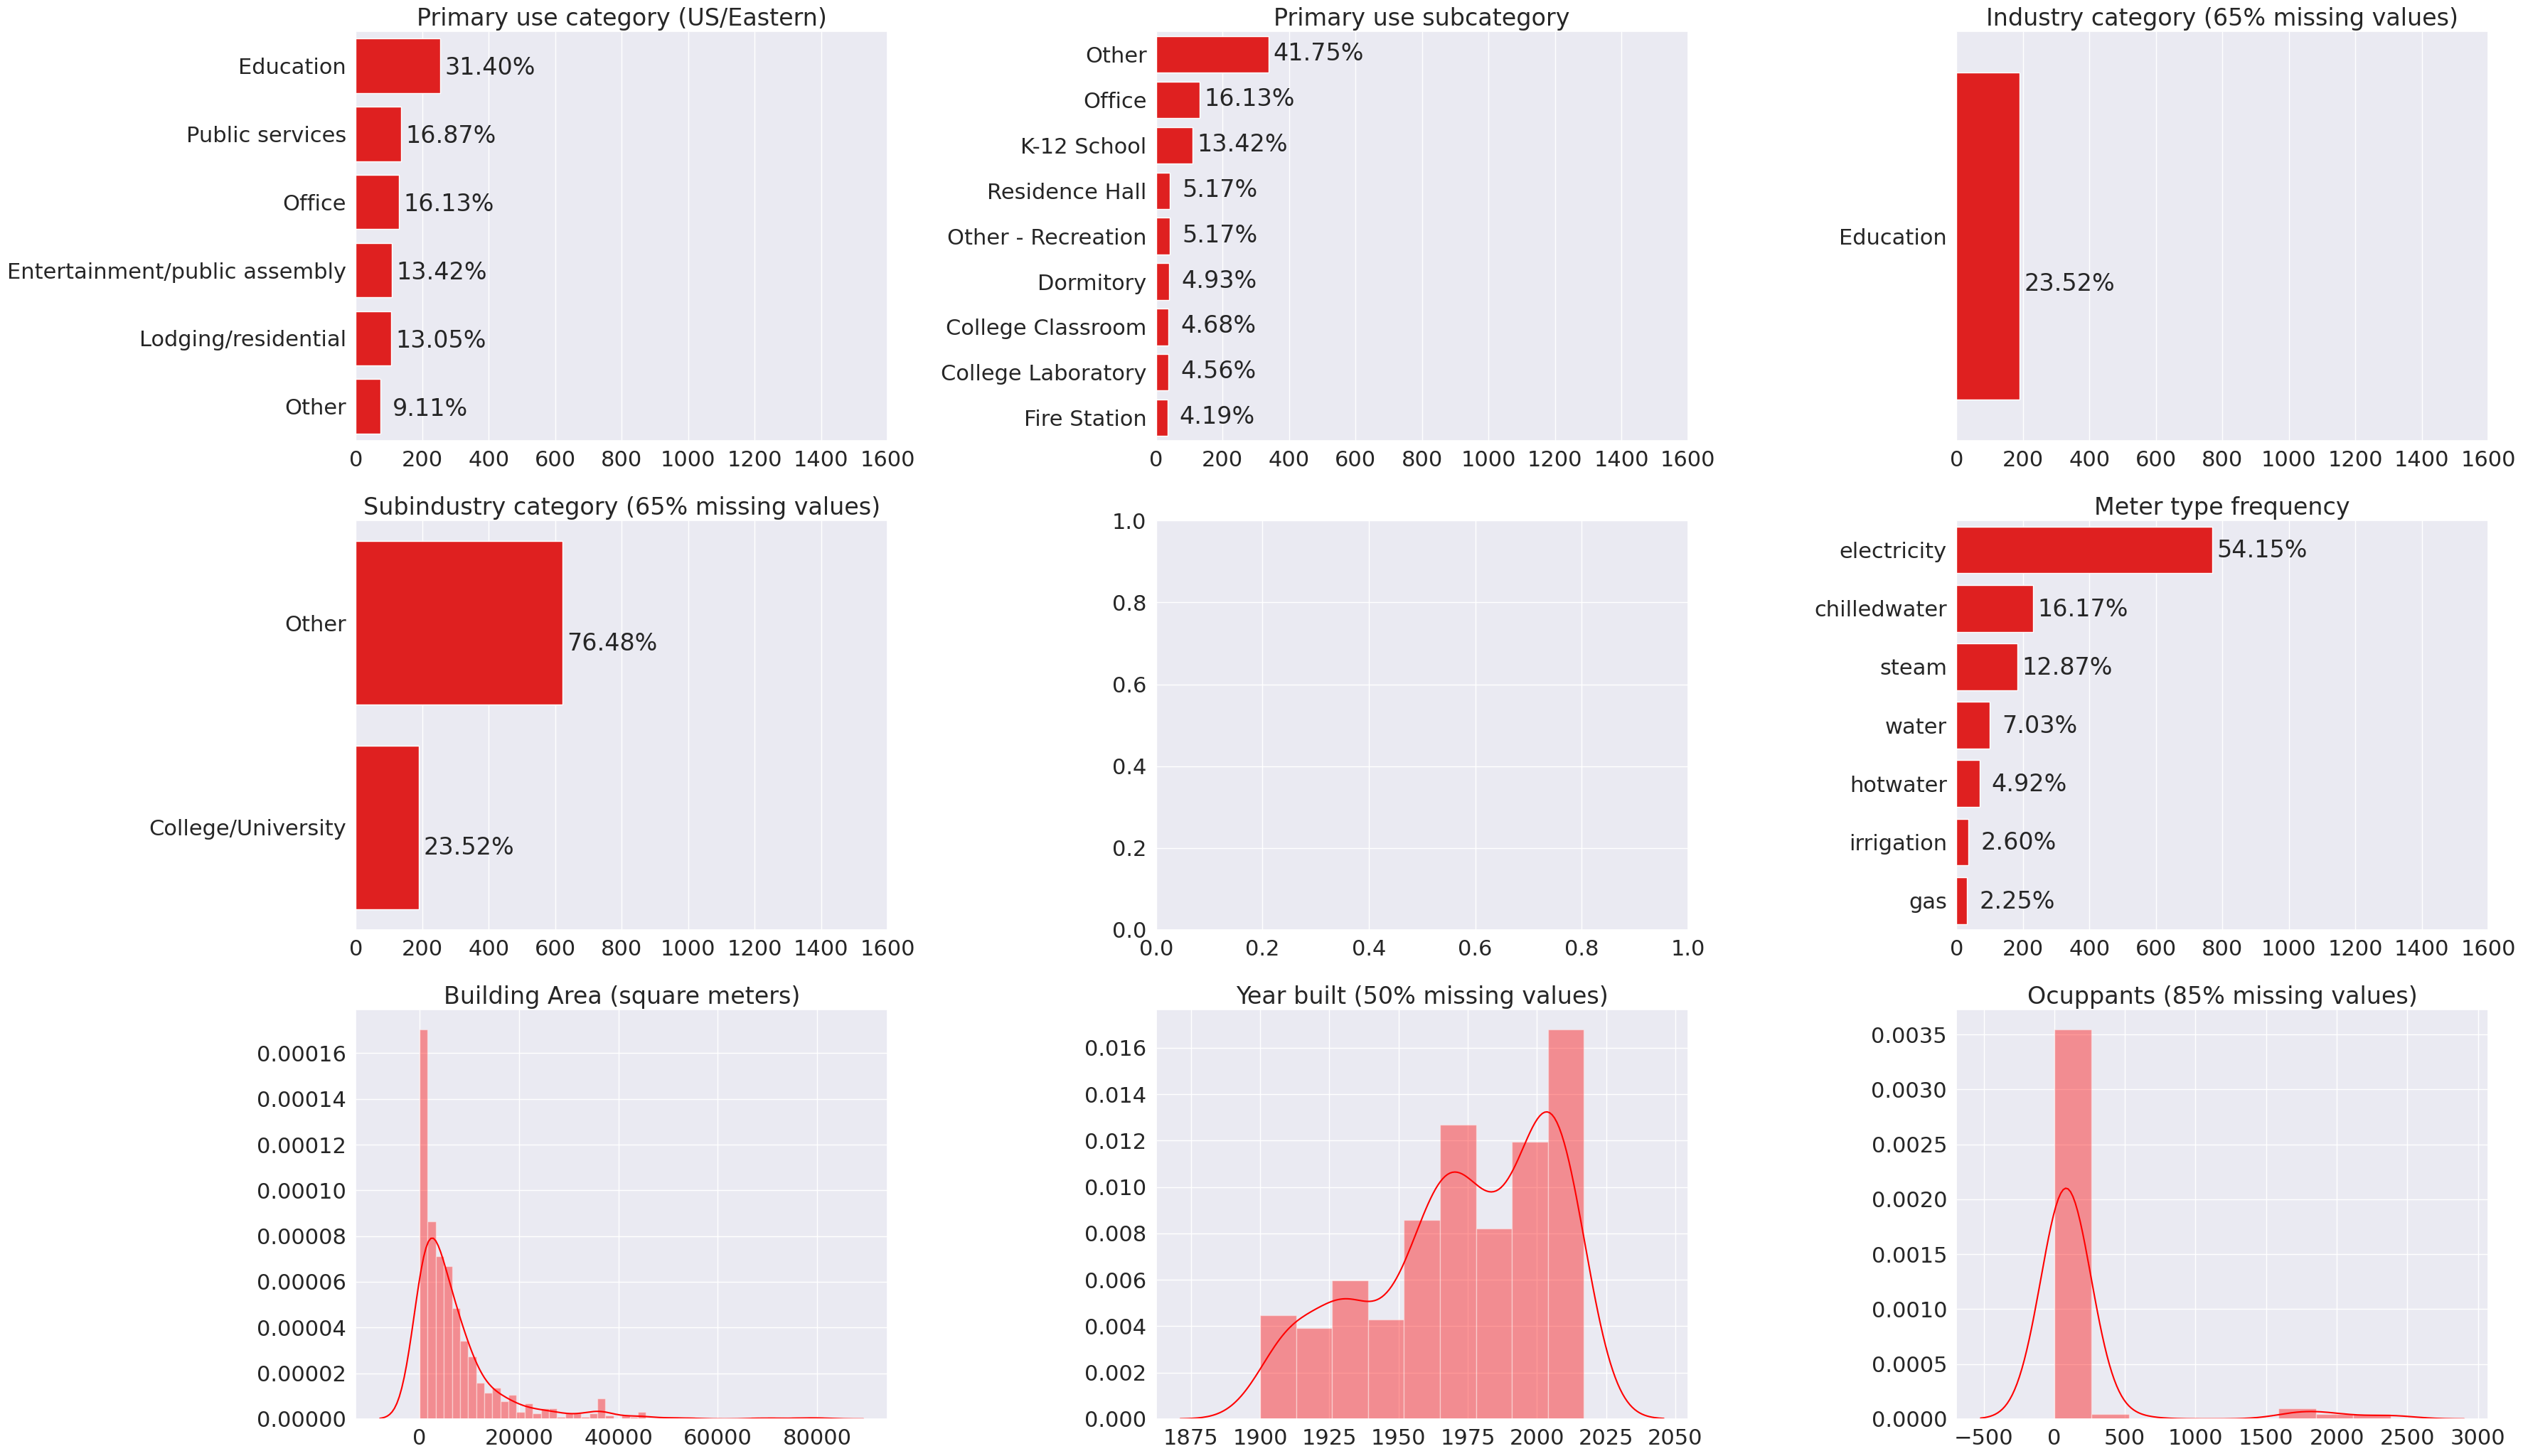

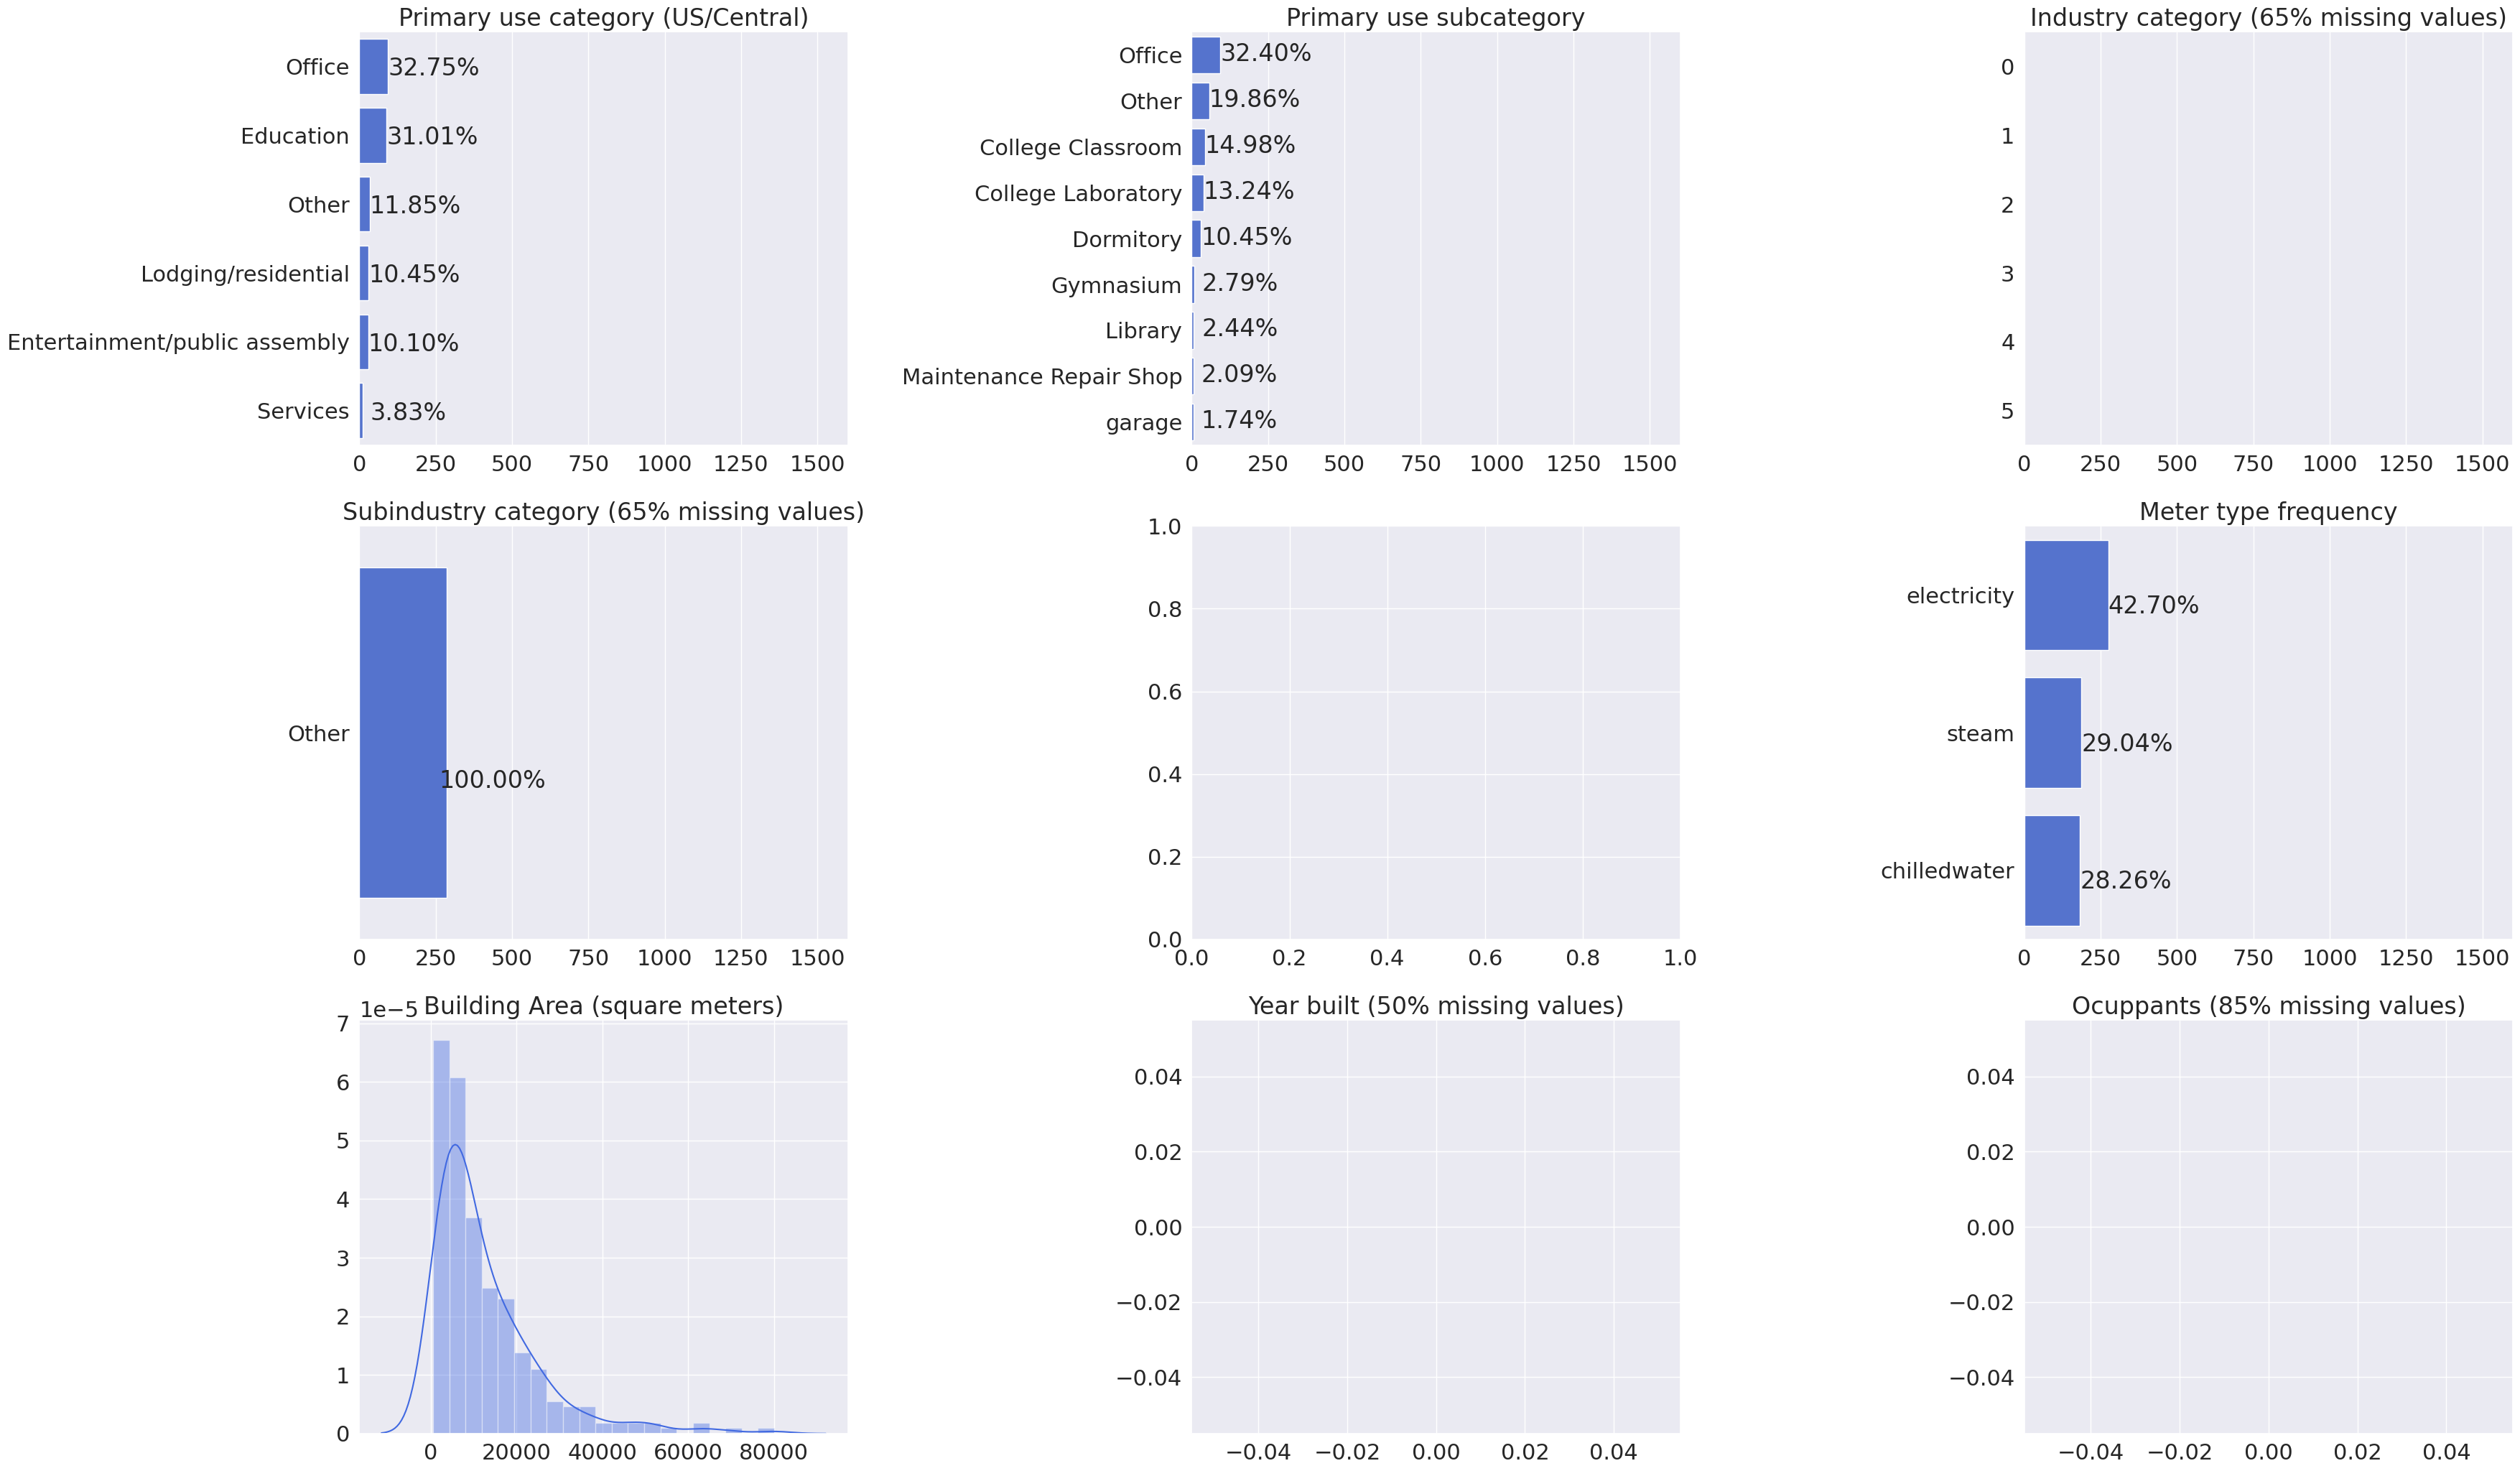

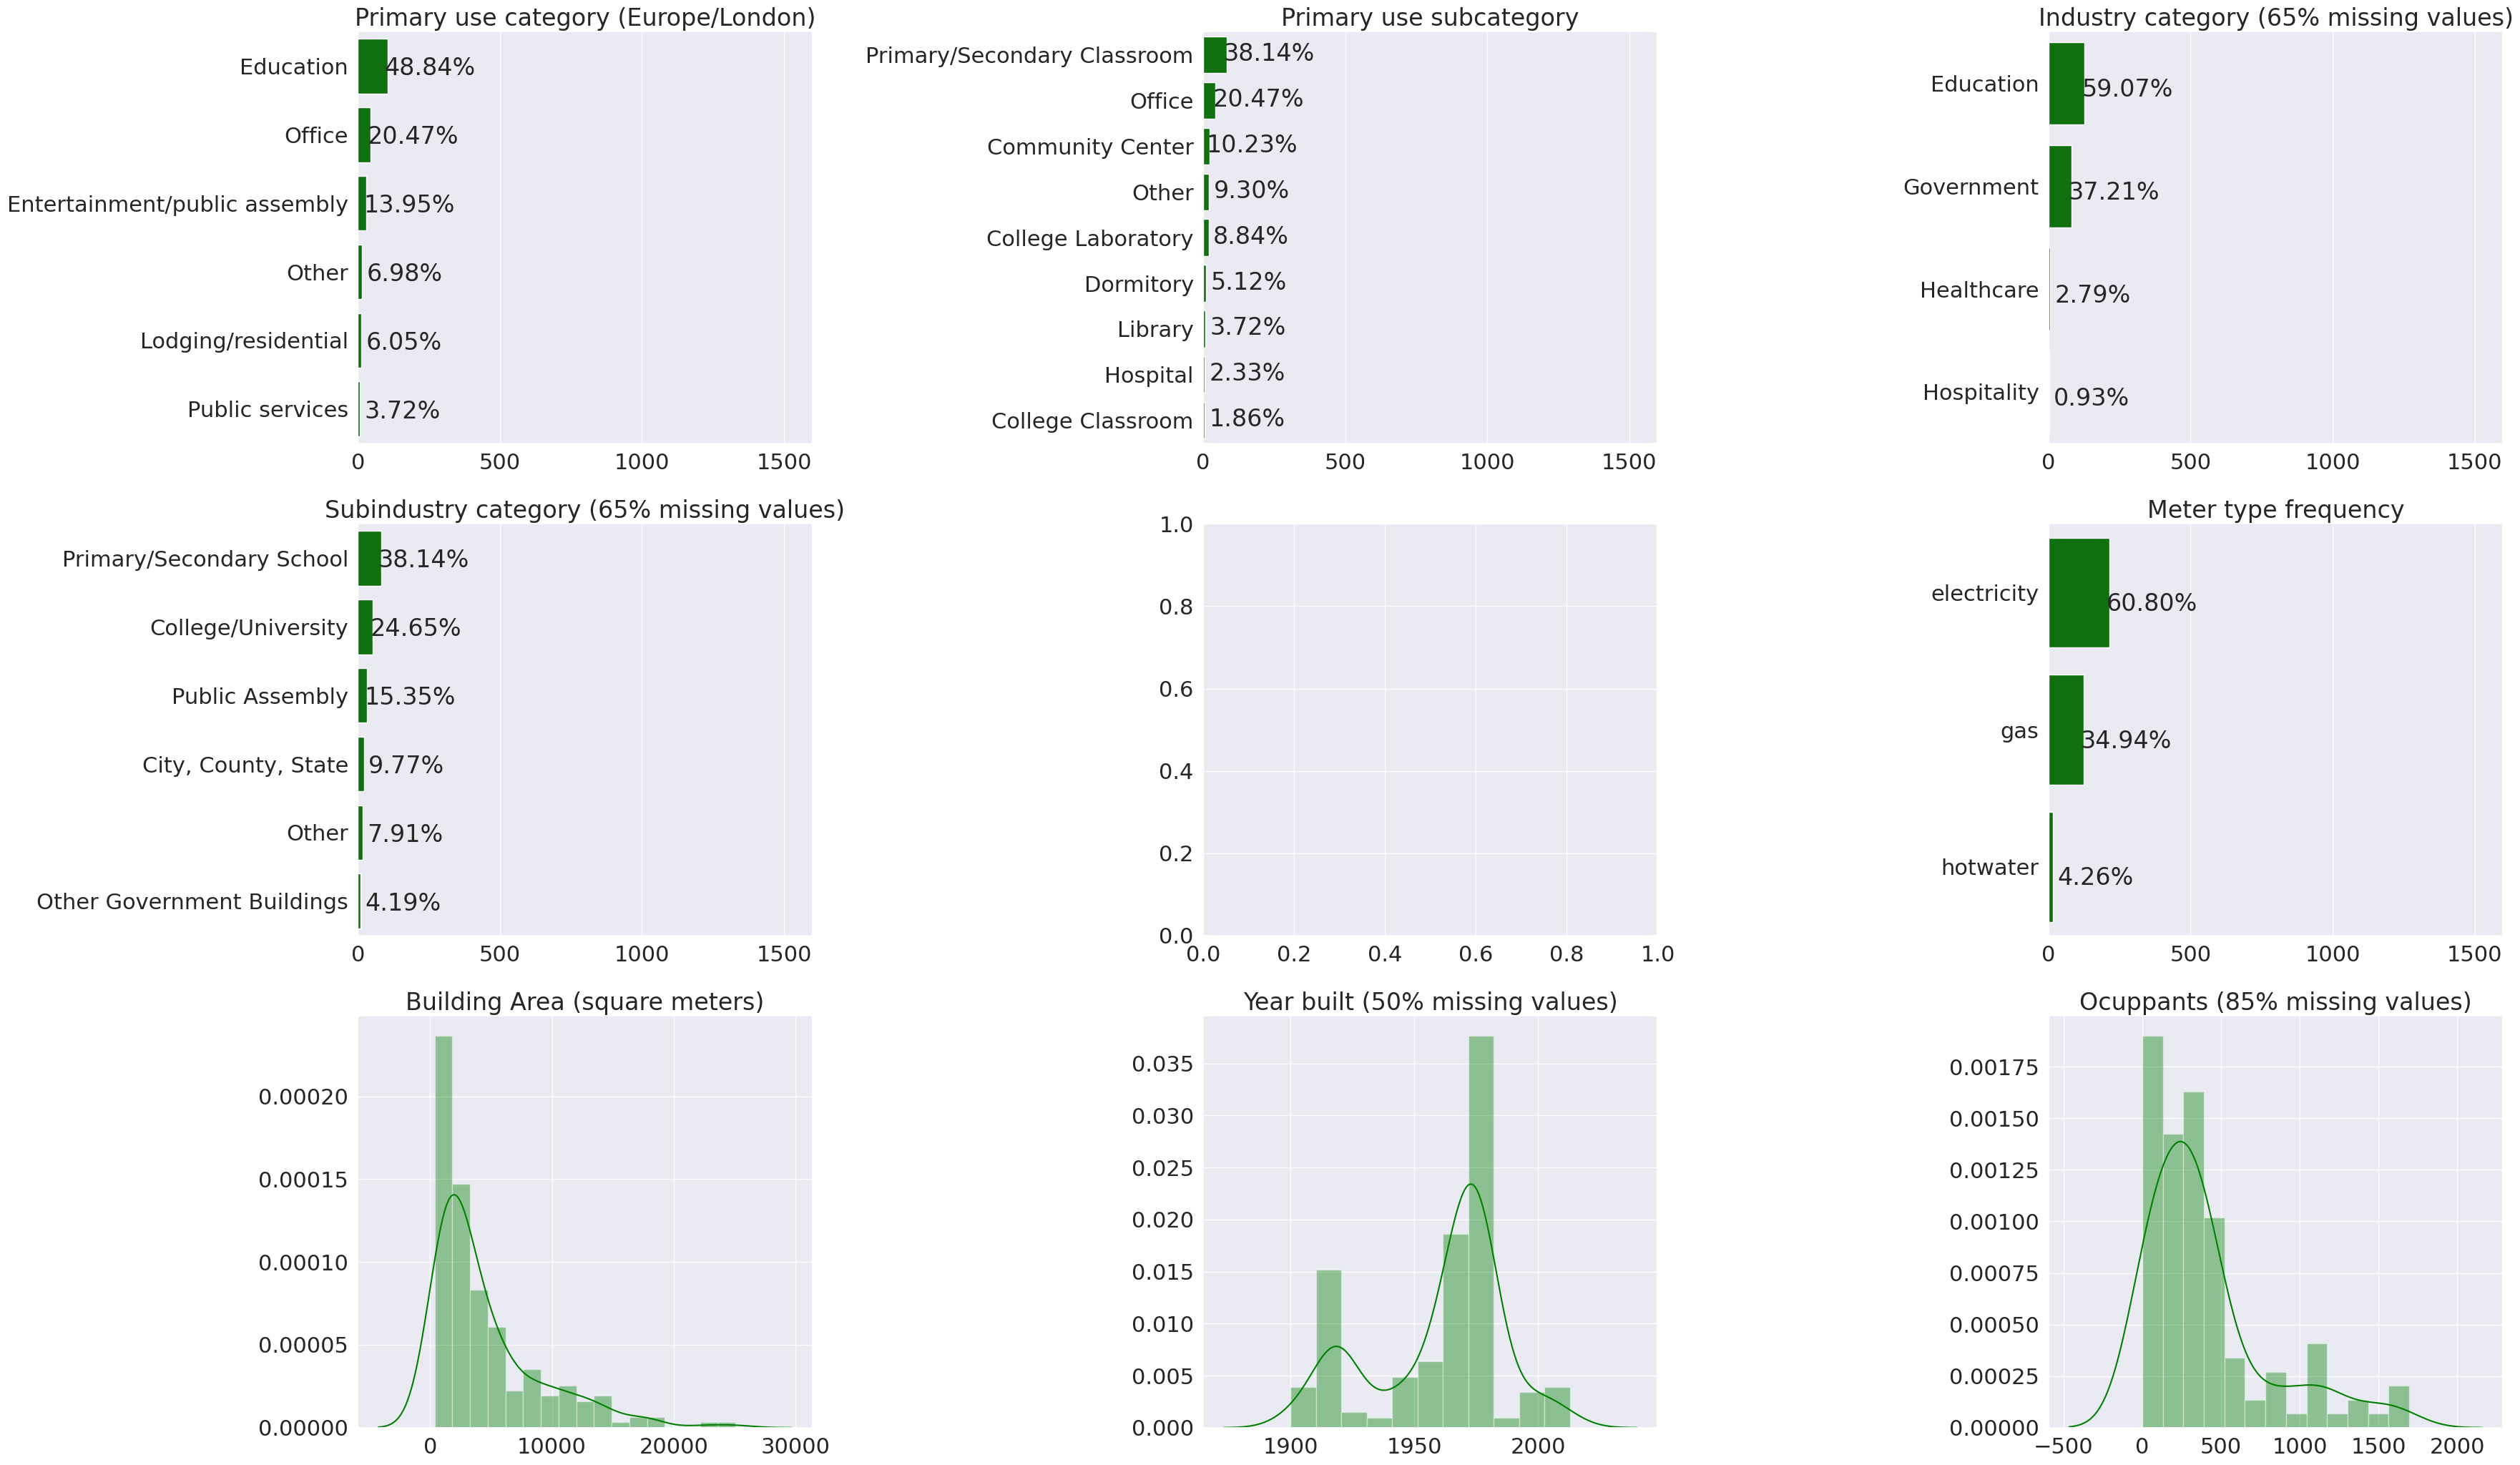

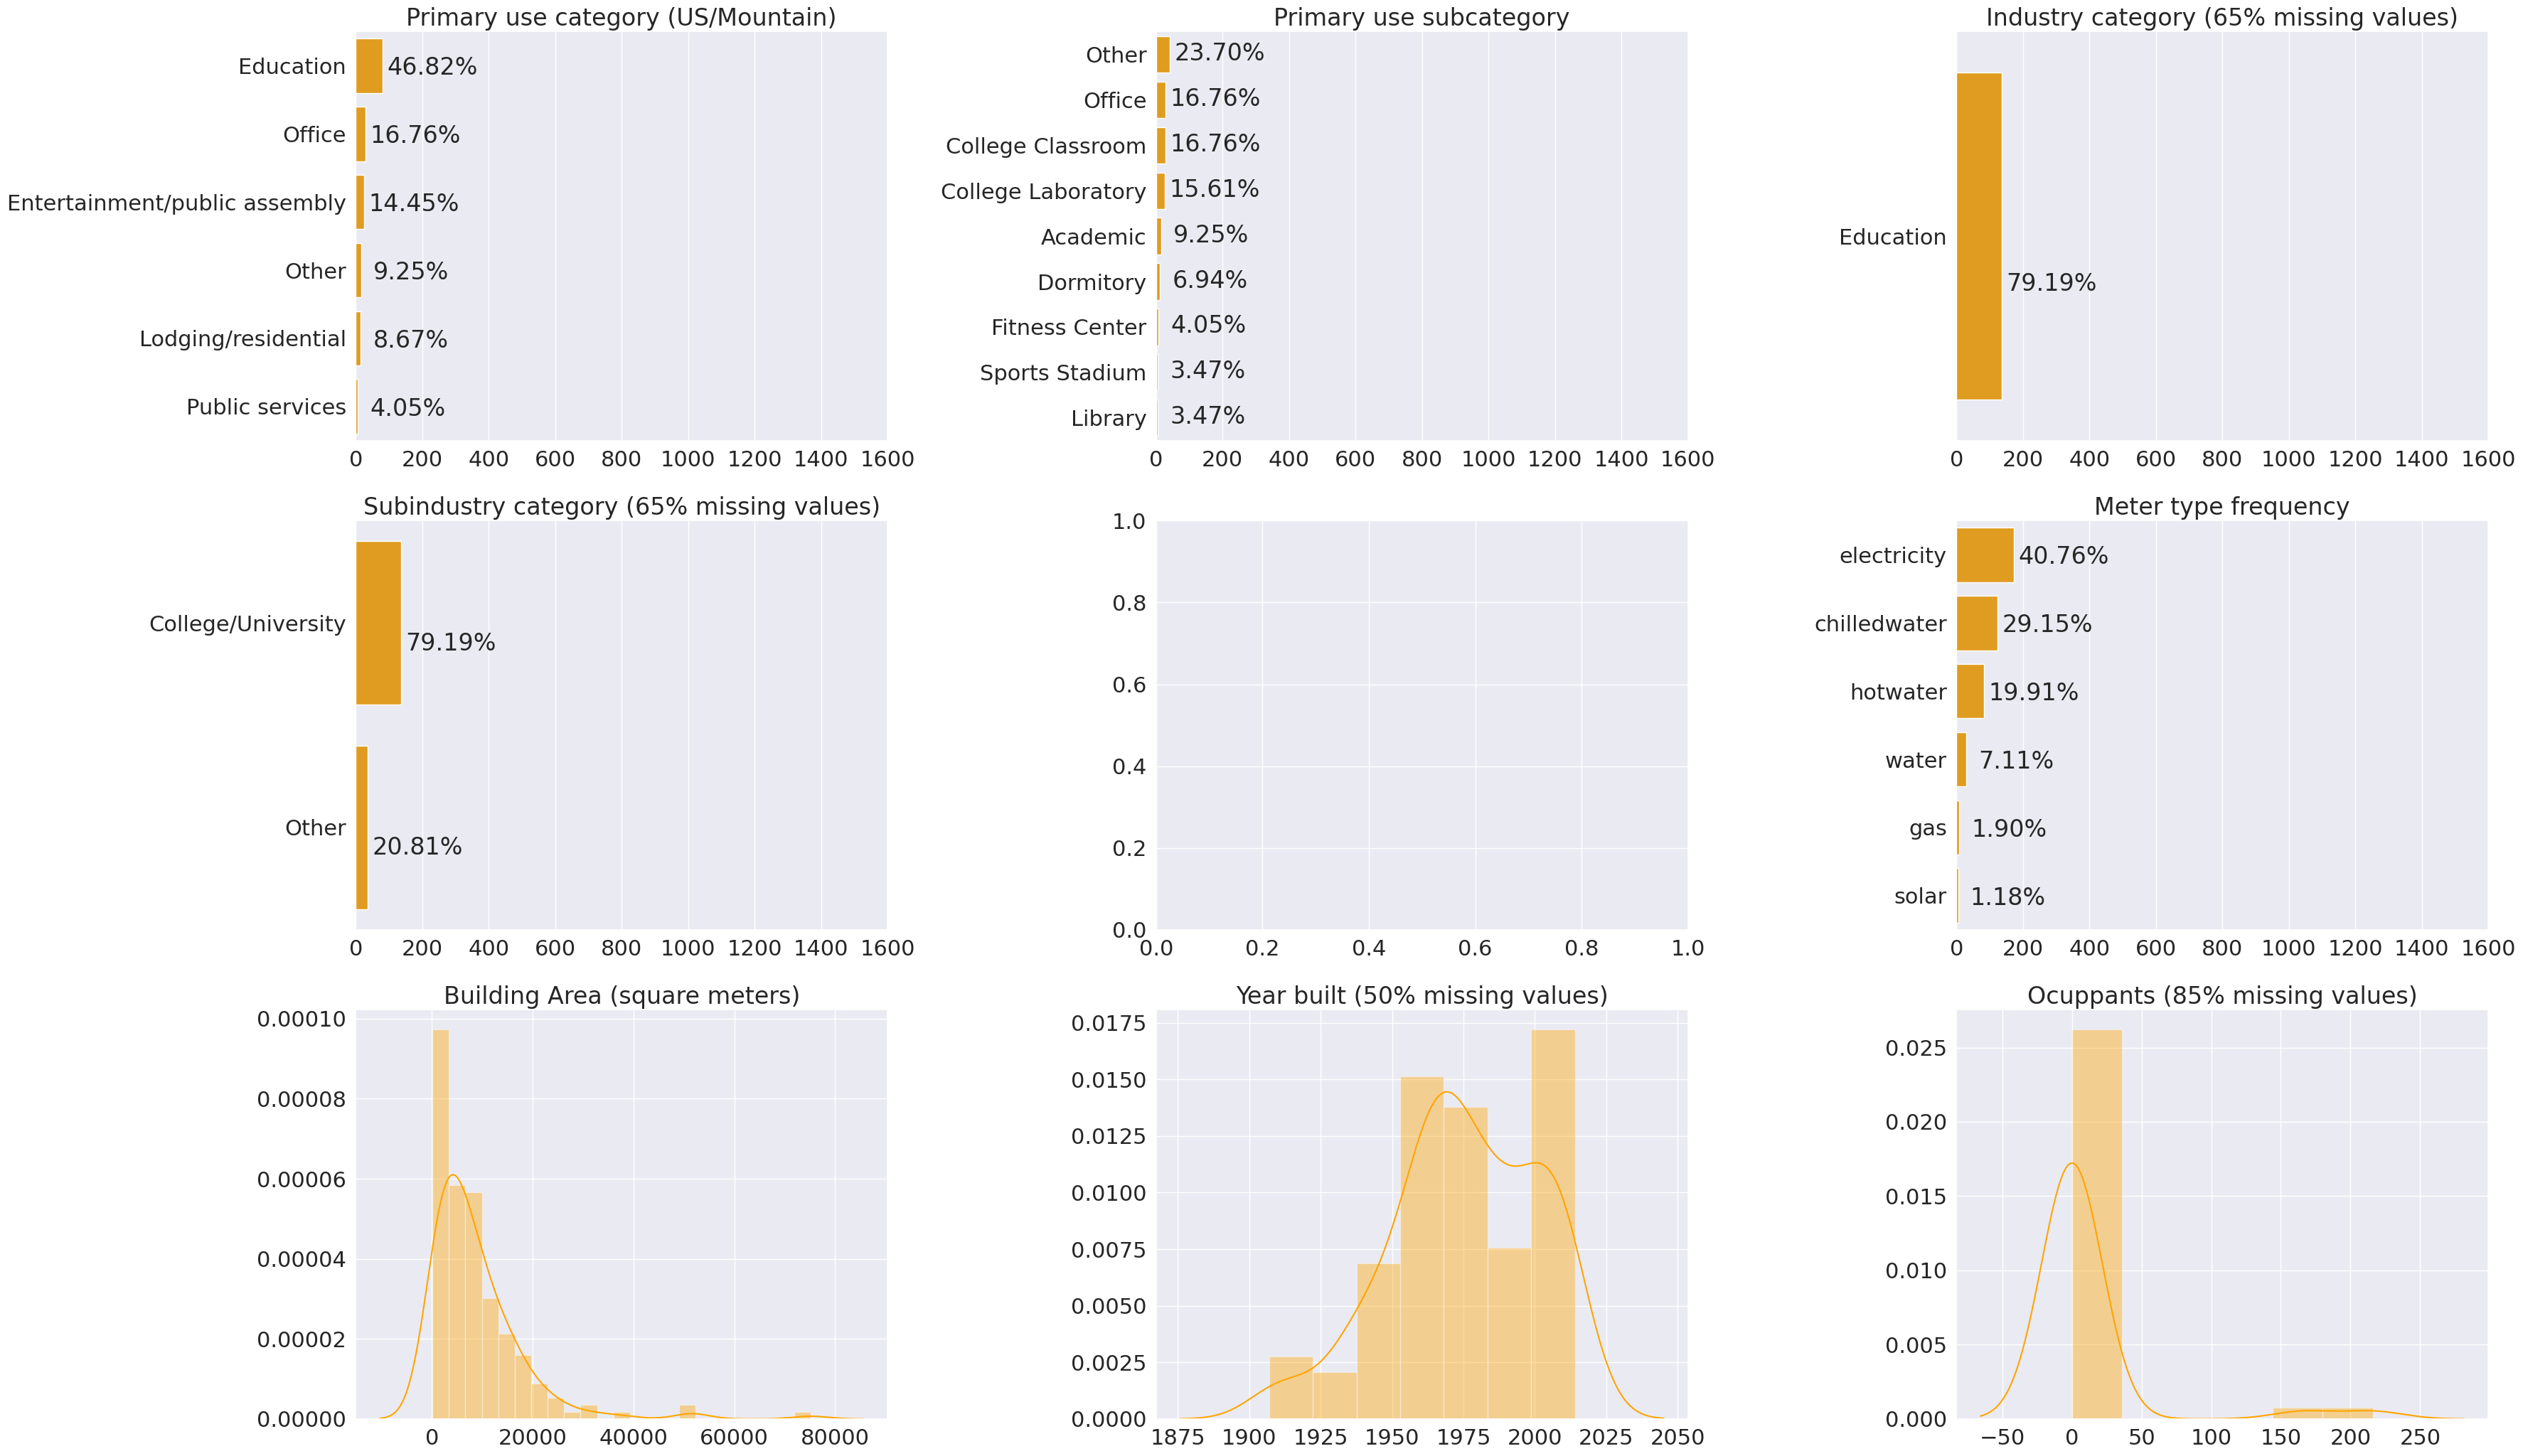

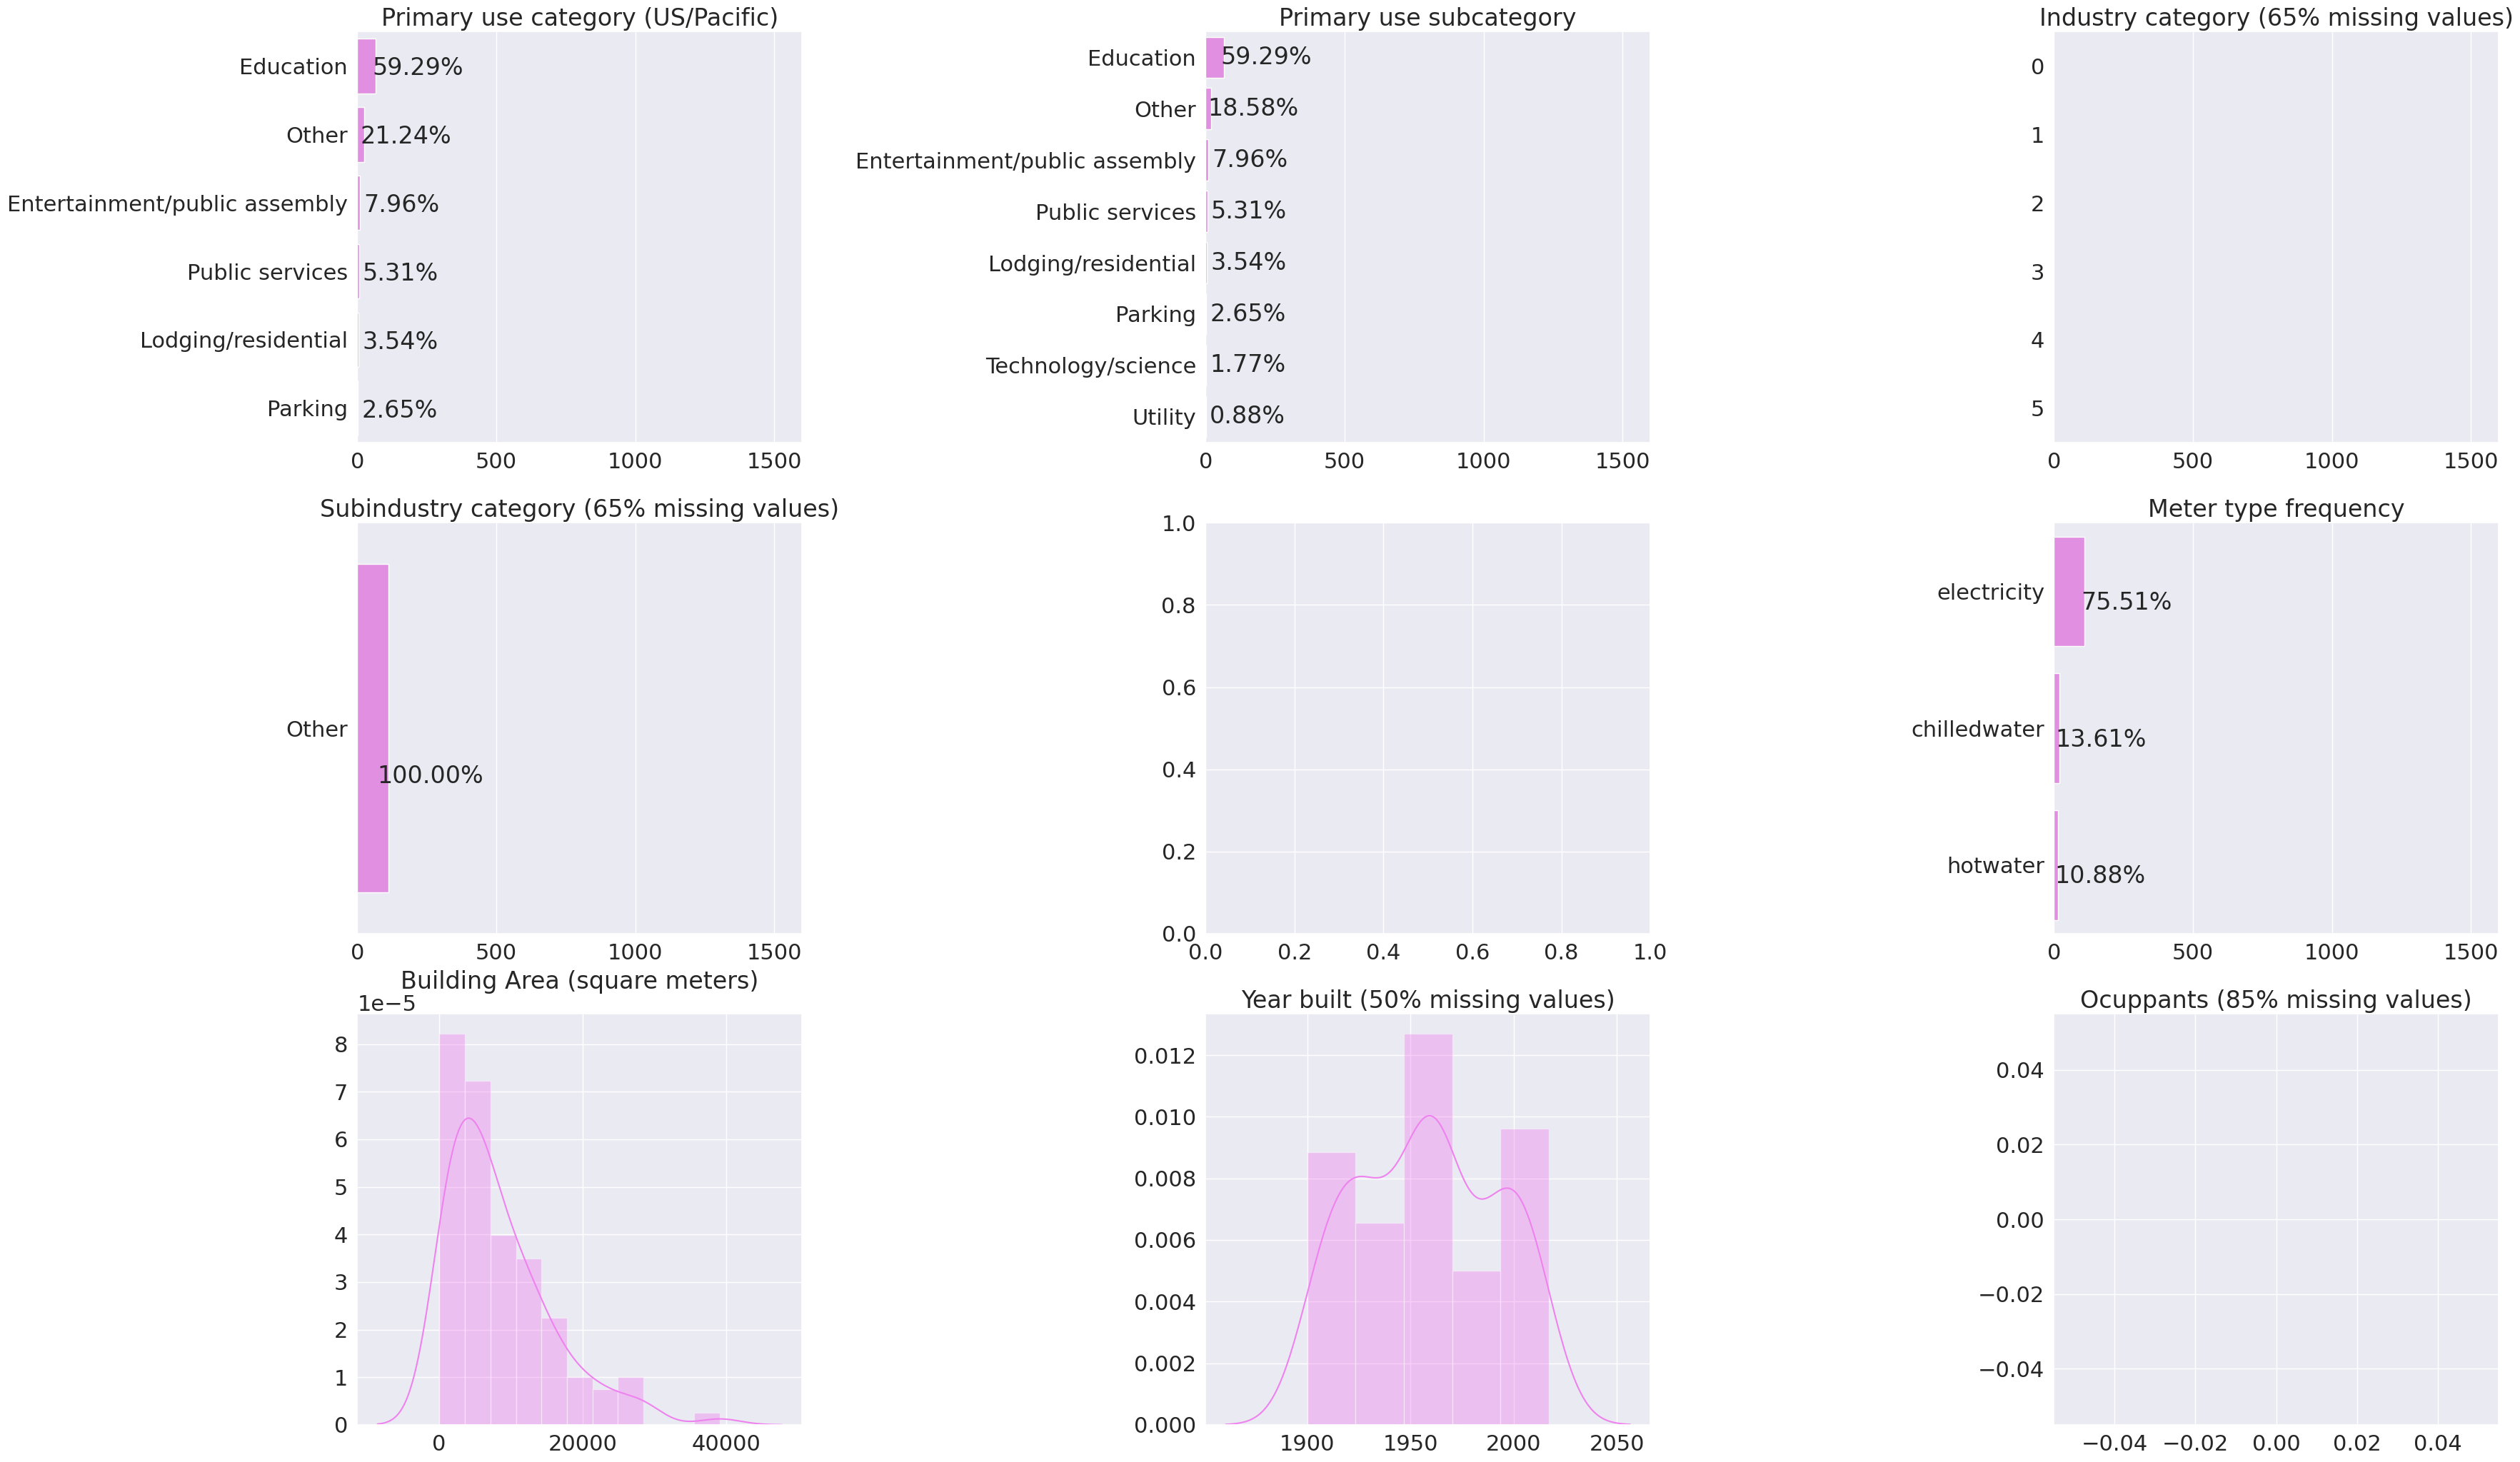

In [40]:
warnings.filterwarnings('ignore')

regions = ["US/Eastern", "US/Central", "Europe/London", "US/Mountain", "US/Pacific"]
region_colors = {"US/Eastern": "red", "US/Central": "royalblue", "US/Mountain": "orange", "US/Pacific":"violet", "Europe/London": "green"}

for region in regions:
    region_metadata = df_metadata[df_metadata["timezone"]== region]

    sns.set(rc={'figure.figsize': (36, 21)})
    sns.set(font_scale=2)
    f, axes = plt.subplots(3, 3)
    axes = axes.flatten()
    color = region_colors[region]

    # primary use category countplot in decreasing order
    top5 = list(region_metadata['primaryspaceusage'].value_counts().iloc[:5].index)
    temp = region_metadata[["primaryspaceusage"]].copy()
    temp.loc[temp.primaryspaceusage.isin(top5) == False, "primaryspaceusage"] = "Other"

    ax1 = axes[0]
    g1 = sns.countplot(data=temp, y="primaryspaceusage", color=color, orient="h", ax=ax1, order=temp['primaryspaceusage'].value_counts().index)
    ax1.title.set_text(f'Primary use category ({region})')
    ax1.set(ylabel="", xlabel="", xlim=(0, 1600))

    total = float(len(region_metadata))
    for p in g1.patches:
        width = p.get_width()
        g1.text(width + 150,
                p.get_y() + p.get_height() / 1.5,
                '{:1.2%}'.format(width / total),
                ha="center")
    del (top5, temp)

    # primary use subcategory countplot in decreasing order
    top5 = list(region_metadata['sub_primaryspaceusage'].value_counts().iloc[:8].index)
    temp = region_metadata[["sub_primaryspaceusage"]].copy()
    temp.loc[temp.sub_primaryspaceusage.isin(top5) == False, "sub_primaryspaceusage"] = "Other"
    # Plot
    ax2 = axes[1]
    g2 = sns.countplot(data=temp, y="sub_primaryspaceusage", color= color, orient="h", ax=ax2, order = temp['sub_primaryspaceusage'].value_counts().iloc[:16].index)
    ax2.title.set_text('Primary use subcategory')
    ax2.set(ylabel="", xlabel="", xlim=(0,1600))
    # adds percentage
    total = float(len(region_metadata)) # number of buildings
    for p in g2.patches:
      width = p.get_width()
      g2.text(width + 150,
              p.get_y() + p.get_height()/1.5,
              '{:1.2%}'.format(width/total),
              ha="center")
    del(top5, temp)

    # industry countplot in decreasing order
    ax3 = axes[2]
    g3 = sns.countplot(data=region_metadata, y="industry", color=color, ax=ax3, orient="h", order = region_metadata['industry'].value_counts().index)
    ax3.title.set_text('Industry category (65% missing values)')
    ax3.set(ylabel="", xlabel="", xlim=(0,1600))
    # adds percentage
    total = float(len(region_metadata)) # number of buildings
    for p in g3.patches:
        width = p.get_width()
        g3.text(width + 150,
              p.get_y() + p.get_height()/1.5,
              '{:1.2%}'.format(width/total),
              ha="center")

    # subindustry countplot in decreasing order
    top5 = list(region_metadata['subindustry'].value_counts().iloc[:5].index)
    temp = region_metadata[["subindustry"]].copy()
    temp.loc[temp.subindustry.isin(top5) == False, "subindustry"] = "Other"
    # Plot
    ax4 = axes[3]
    g4 = sns.countplot(data=temp, y="subindustry", color=color, ax=ax4, orient="h", order = temp['subindustry'].value_counts().index)
    ax4.title.set_text('Subindustry category (65% missing values)')
    ax4.set(ylabel="", xlabel="", xlim=(0,1600))
    # adds percentage
    total = float(len(region_metadata)) # number of buildings
    for p in g4.patches:
        width = p.get_width()
        g4.text(width + 150,
              p.get_y() + p.get_height()/1.5,
              '{:1.2%}'.format(width/total),
              ha="center")
    del(top5, temp)


    # Meters type frequency
    ax6 = axes[5]
    # Temporal datafram
    temp = pd.melt(region_metadata[["building_id","electricity","hotwater","chilledwater","steam","water","irrigation","gas","solar"]],id_vars = "building_id", var_name="meter")
    # plot
    g6 = sns.countplot(data=temp.loc[temp['value']=="Yes"], y='meter', color= color, ax=ax6, orient="h", order = temp.loc[temp['value']=="Yes"]["meter"].value_counts().index)
    g6.title.set_text('Meter type frequency')
    g6.set(ylabel="", xlabel="", xlim=(0,1600))
    # adds percentage
    total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0] # number of meters
    for p in g6.patches:
        width = p.get_width()
        g6.text(width + 150,
              p.get_y() + p.get_height()/1.5,
              '{:1.2%}'.format(width/total),
              ha="center")
    del(temp)

    # "sqft" histogram
    ax7 = axes[6]
    g7 = sns.distplot(region_metadata["sqm"], ax=ax7, color=color)
    g7.set(ylabel="", xlabel="")
    ax7.set_title('Building Area (square meters)')

    # "yearbuilt" histogram
    ax8 = axes[7]
    g8 = sns.distplot(region_metadata["yearbuilt"].dropna(), ax=ax8, color=color)
    g8.set(ylabel="", xlabel="")
    ax8.set_title('Year built (50% missing values)')

    # "occupants" histogram
    ax9 = axes[8]
    g9 = sns.distplot(region_metadata["occupants"].dropna(), ax=ax9, color=color)
    g9.set(ylabel="", xlabel="")
    ax9.set_title('Ocuppants (85% missing values)')


    plt.tight_layout()
    plt.show()





As we can see here, there are a lot of missing values across each "timezone". For instance, there is no information about the industry category or amount of occupants for the US/Central or US/Pacific timezones.

Nevertheless, we can start seeing some differences:

- In most regions, the buildings' purpose is education, whereas in US/Central, most buildings are used as offices.

- Use subcategories do not bring us much information, as in most cases their use is described as "other".

- Most meter types measure electricity, but chilled water is the next most frequent in the Eastern, mountaineous and pacific regions of the US, whereas gas is the next most frequent in London and steam was the second most frequent in the central US.

- The median year of construction differs a lot across regions: a lot of buildings in the Eastern US seem to have been build in the early 2000s, but in London and the US/Mountain region a lot of building seem to date from the 60s. For the US Pacific it is a lot harder to tell since there appears to have been a steady rate of constructions from the 1900s to the early 2000s.

- Building area is quite difficult to interpret overall since in most cases we are presented with a right skewed distribution across a wide range of surfaces

## Merge the data